In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Input, Multiply, Activation
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/NO2_sensor_and_council.csv')
data.head()

,Datetime,NO2_ppb_sensor,NO2_µg/m³_council
0,2024-08-15 15:00:00,5.083429,10.53788
1,2024-08-19 11:00:00,2.796090,21.97463
2,2024-08-19 12:00:00,2.472661,19.66528
3,2024-08-19 13:00:00,7.702129,14.77406
4,2024-08-19 14:00:00,1.452424,15.36216


In [3]:
X = data[['NO2_ppb_sensor']].values
y = data['NO2_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[2.64740058],
       [0.54764795],
       [2.47266105],
       [0.56236447],
       [0.37980413]])

array([[ 0.43998907],
       [-0.74091593],
       [ 0.34171521],
       [-0.73263933],
       [-0.83531162]])

array([[1.46094132],
       [0.10452187],
       [5.08342942],
       [1.75736312],
       [0.80743062]])

array([[-0.22727794],
       [-0.99013091],
       [ 1.81001647],
       [-0.06056974],
       [-0.59481364]])

In [7]:
def build_keras_model(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [8]:
def build_rnn_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(SimpleRNN(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [9]:
def build_gru_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(GRU(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(GRU(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [10]:
def build_lstm_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()

    for i in range(layers):
        if i == 0:
            model.add(LSTM(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(LSTM(units[i], return_sequences=False))
    
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [11]:
def build_keras_model_with_attention(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    
    attention = Dense(1, activation='tanh')(model.layers[-1].output)
    attention = Activation('softmax')(attention)
    attention = Multiply()([model.layers[-1].output, attention])
    
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
def build_rnn_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    rnn_out = inputs
    for i in range(layers):
        rnn_out = SimpleRNN(units[i], return_sequences=True if layers > 1 else False)(rnn_out)
    
    attention = Dense(1, activation='tanh')(rnn_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([rnn_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [13]:
def build_gru_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    gru_out = inputs
    for i in range(layers):
        gru_out = GRU(units[i], return_sequences=True if layers > 1 else False)(gru_out)
    
    attention = Dense(1, activation='tanh')(gru_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([gru_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [14]:
def build_lstm_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    lstm_out = inputs
    
    for i in range(layers):
        lstm_out = LSTM(units[i], return_sequences=True if layers > 1 else False)(lstm_out)
    
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([lstm_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

## Experimented List of Models and Parameters

#### The MLPRegressor: This model optimizes the squared error using LBFGS or stochastic gradient descent.
#### The KerasRegressor: Wrapper that enables Keras models so that they can be used as part of a Scikit-Learn workflow

In [15]:
models = {
    'MLP Regressor': MLPRegressor(random_state=42, verbose=0),
    'Keras Regressor': KerasRegressor(build_fn=build_keras_model, verbose=0),
    'RNN Regressor': KerasRegressor(build_fn=build_rnn_model, verbose=0),
    'GRU Regressor': KerasRegressor(build_fn=build_gru_model, verbose=0),
    'LSTM Regressor': KerasRegressor(build_fn=build_lstm_model, verbose=0),
    'MLP Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'Keras Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'RNN Regressor with Attention': KerasRegressor(build_fn=build_rnn_model_with_attention, verbose=0),
    'GRU Regressor with Attention': KerasRegressor(build_fn=build_gru_model_with_attention, verbose=0),
    'LSTM Regressor with Attention': KerasRegressor(build_fn=build_lstm_model_with_attention, verbose=0),
}

params = {
    'MLP Regressor': {
        'hidden_layer_sizes': [(50, 50), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 400],
    },
    'Keras Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'MLP Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'Keras Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    }
}

#### 1. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 2. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [16]:
best_models = []

best_score = float('inf')
best_params = None
best_model_name = ''

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    grid = GridSearchCV(estimator=model, param_grid=params[model_name], n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
    grid_result = grid.fit(X_train_scaled, y_train)
    
    try:
        best_models.append({
            'name': model_name,
            'model': grid_result.best_estimator_,
            'params': grid_result.best_params_,
            'rmse': -grid_result.best_score_
        })
    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training MLP Regressor...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Training Keras Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training MLP Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training Keras Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


#### For showcasing model with the best R2

In [17]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled) 
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

In [18]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: RNN Regressor
Best Hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 3.9504
Test MSE: 15.6053
Test R2: 0.0359
Test MAE: 2.6864


,Actual,Predicted
0,10.86300,12.587023
1,11.44631,11.564238
2,10.53788,11.951240
3,11.79534,12.620964
4,8.97919,12.280344
5,12.96675,12.443423
6,7.97513,11.965012
7,21.97463,12.378459


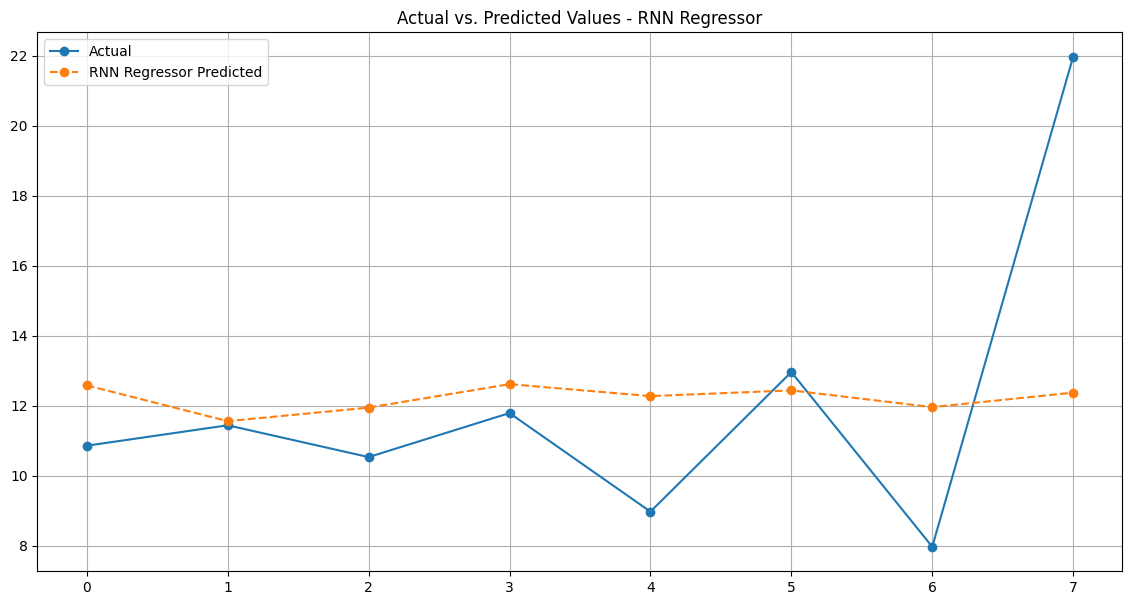


Results For Model: RNN Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 3.9540
Test MSE: 15.6345
Test R2: 0.0341
Test MAE: 2.8741


,Actual,Predicted
0,10.86300,12.710013
1,11.44631,12.282651
2,10.53788,12.634192
3,11.79534,12.764235
4,8.97919,12.542143
5,12.96675,12.850188
6,7.97513,12.420214
7,21.97463,12.855158


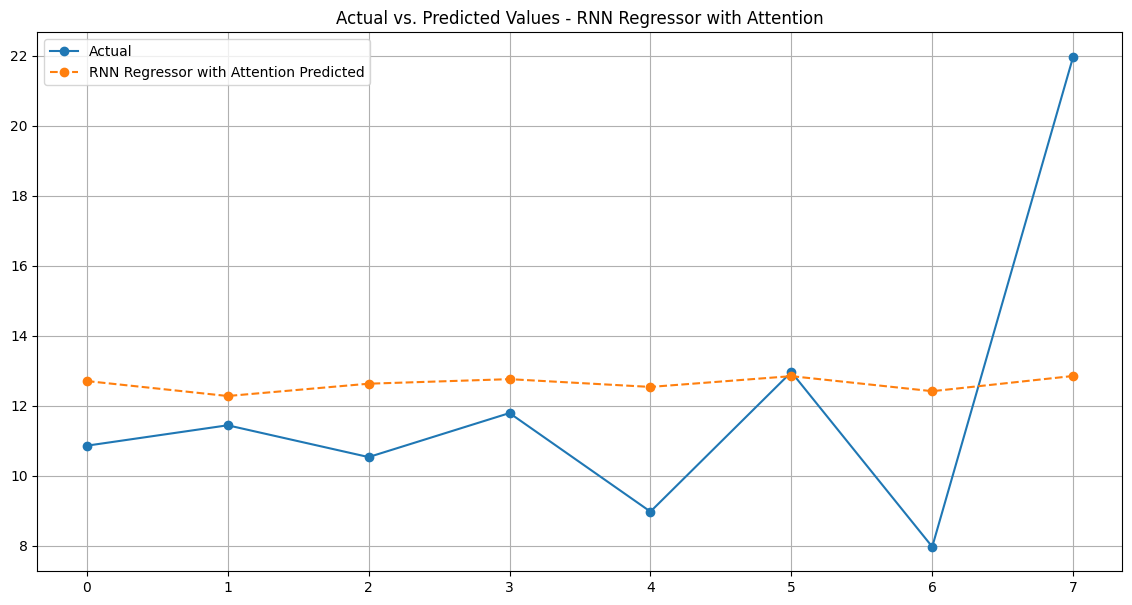


Results For Model: GRU Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 4.0612
Test MSE: 16.4934
Test R2: -0.0189
Test MAE: 2.9718


,Actual,Predicted
0,10.86300,12.429970
1,11.44631,12.487477
2,10.53788,13.332133
3,11.79534,12.447055
4,8.97919,12.430091
5,12.96675,12.558274
6,7.97513,12.452084
7,21.97463,12.590794


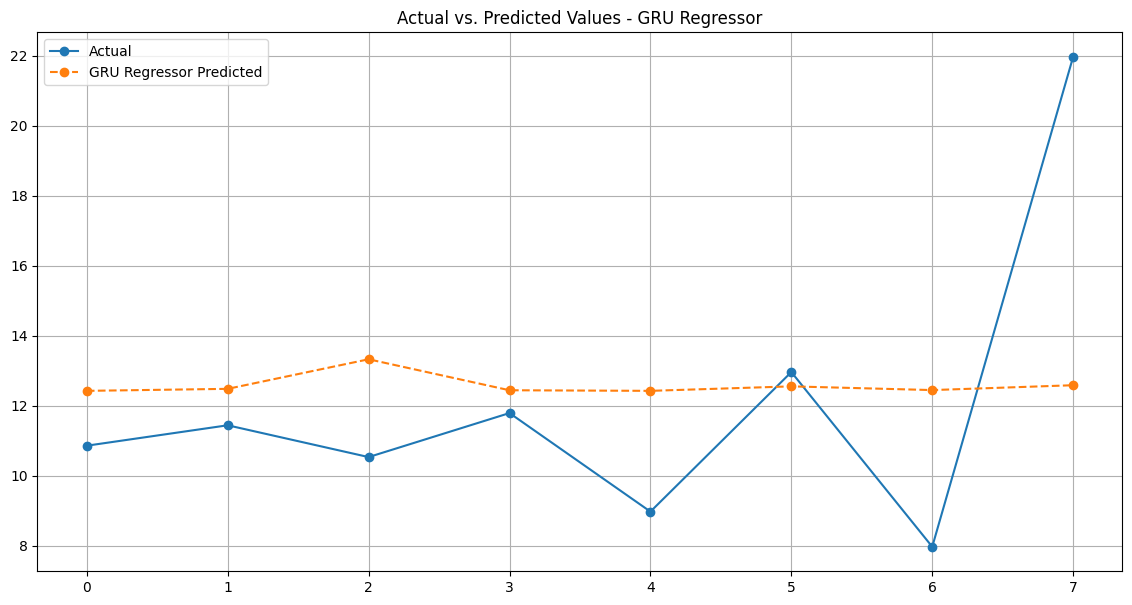


Results For Model: GRU Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 4.1230
Test MSE: 16.9989
Test R2: -0.0502
Test MAE: 3.0501


,Actual,Predicted
0,10.86300,12.638346
1,11.44631,12.808322
2,10.53788,12.617067
3,11.79534,12.609670
4,8.97919,12.713269
5,12.96675,12.548904
6,7.97513,12.760203
7,21.97463,12.541517


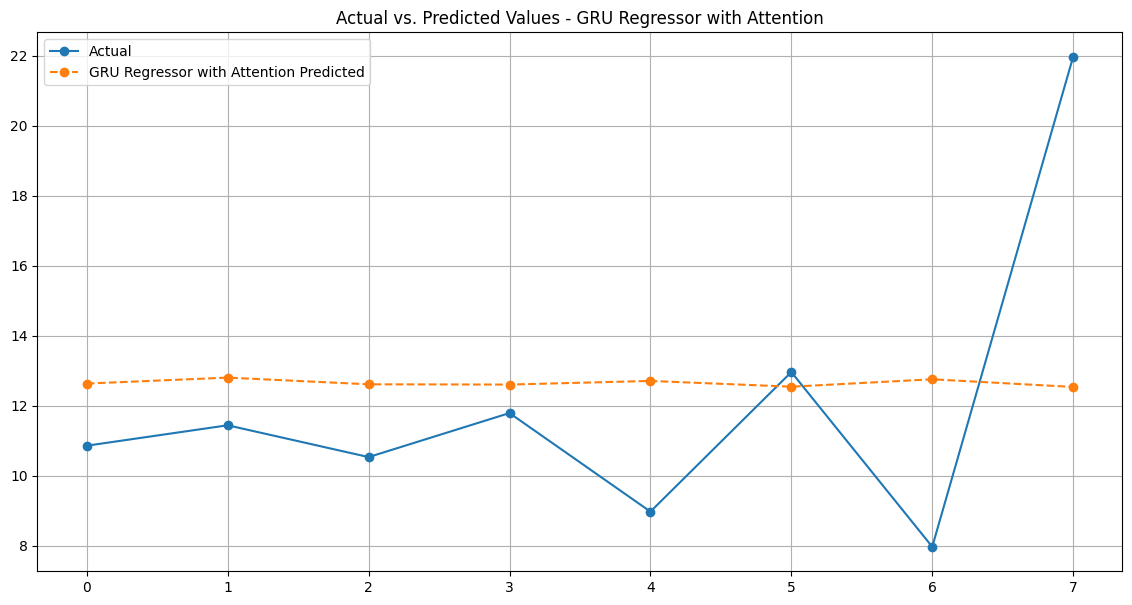


Results For Model: LSTM Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 4.2467
Test MSE: 18.0346
Test R2: -0.1141
Test MAE: 3.1521


,Actual,Predicted
0,10.86300,12.392198
1,11.44631,13.029035
2,10.53788,13.115592
3,11.79534,12.313763
4,8.97919,12.644622
5,12.96675,12.221690
6,7.97513,12.827106
7,21.97463,12.228470


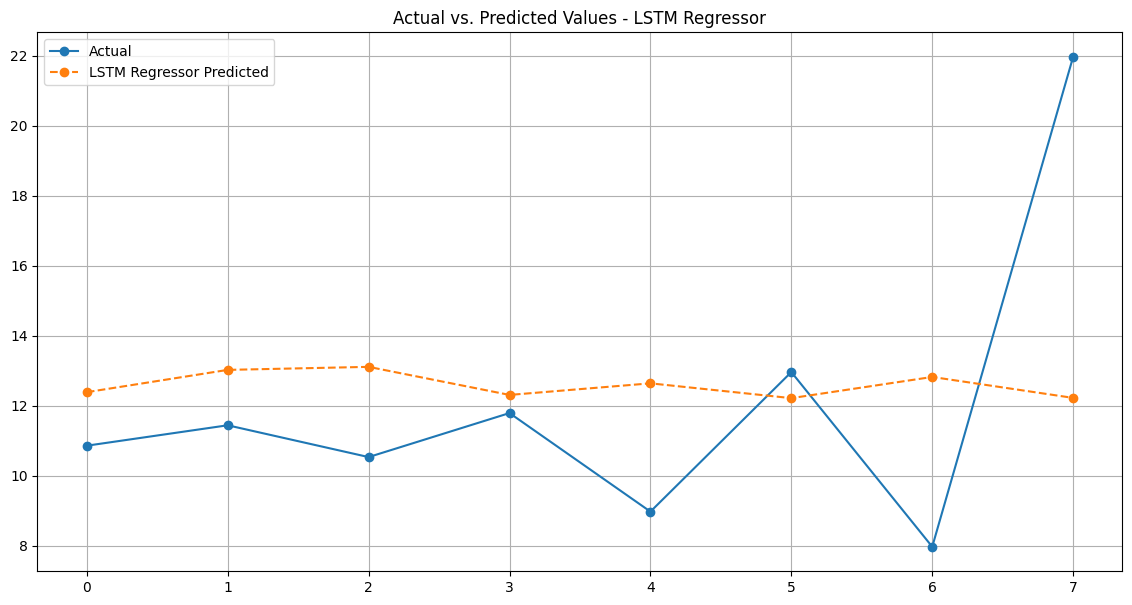


Results For Model: LSTM Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 4.5032
Test MSE: 20.2784
Test R2: -0.2528
Test MAE: 2.9889


,Actual,Predicted
0,10.86300,11.553158
1,11.44631,12.770414
2,10.53788,11.061625
3,11.79534,11.332464
4,8.97919,12.109334
5,12.96675,10.845912
6,7.97513,12.442235
7,21.97463,10.782751


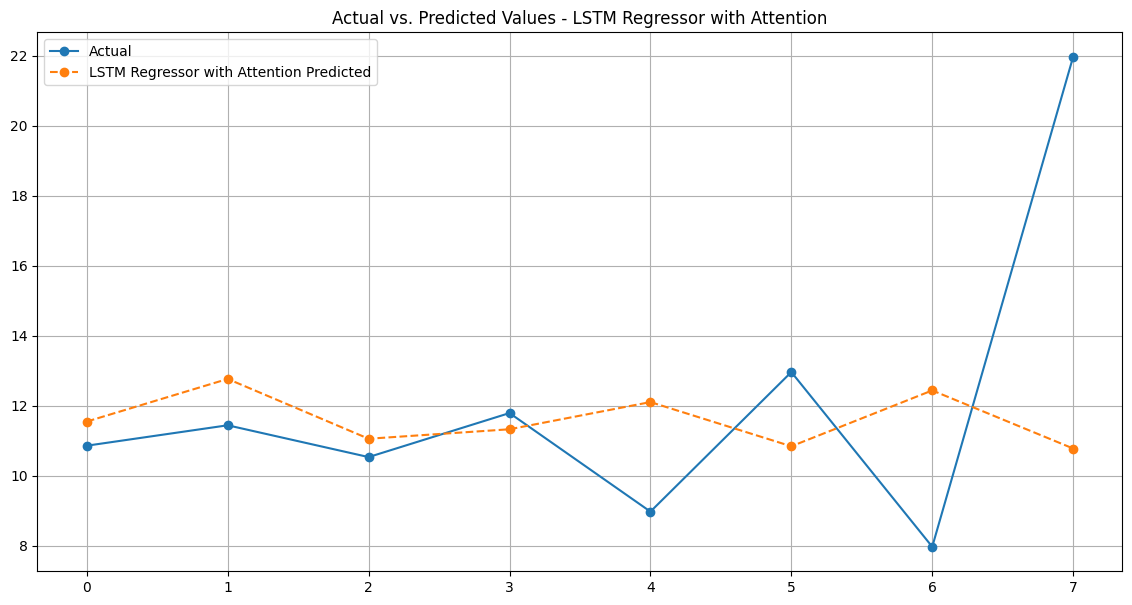


Results For Model: MLP Regressor
Best Hyperparameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'adam'}
Test RMSE: 4.8186
Test MSE: 23.2186
Test R2: -0.4344
Test MAE: 3.4018


,Actual,Predicted
0,10.86300,11.384099
1,11.44631,13.481049
2,10.53788,12.358939
3,11.79534,11.110344
4,8.97919,12.012192
5,12.96675,10.308744
6,7.97513,12.614118
7,21.97463,10.152307


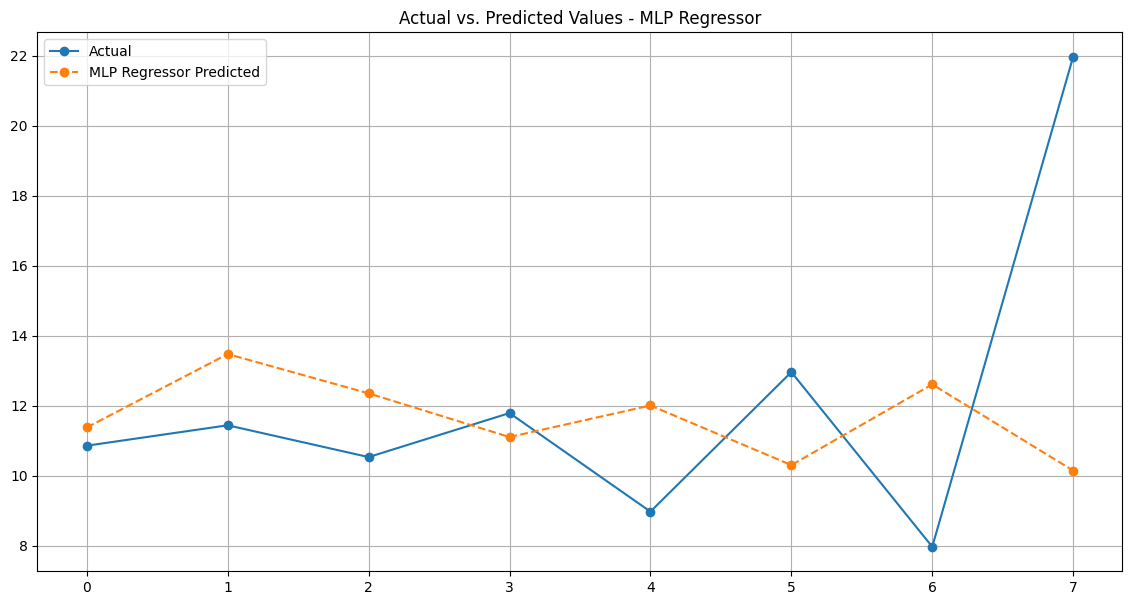


Results For Model: Keras Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'rmsprop'}
Test RMSE: 8.1464
Test MSE: 66.3644
Test R2: -3.0999
Test MAE: 6.0718


,Actual,Predicted
0,10.86300,3.656207
1,11.44631,11.684559
2,10.53788,12.763443
3,11.79534,2.038314
4,8.97919,7.508152
5,12.96675,4.163612
6,7.97513,9.632948
7,21.97463,4.759503


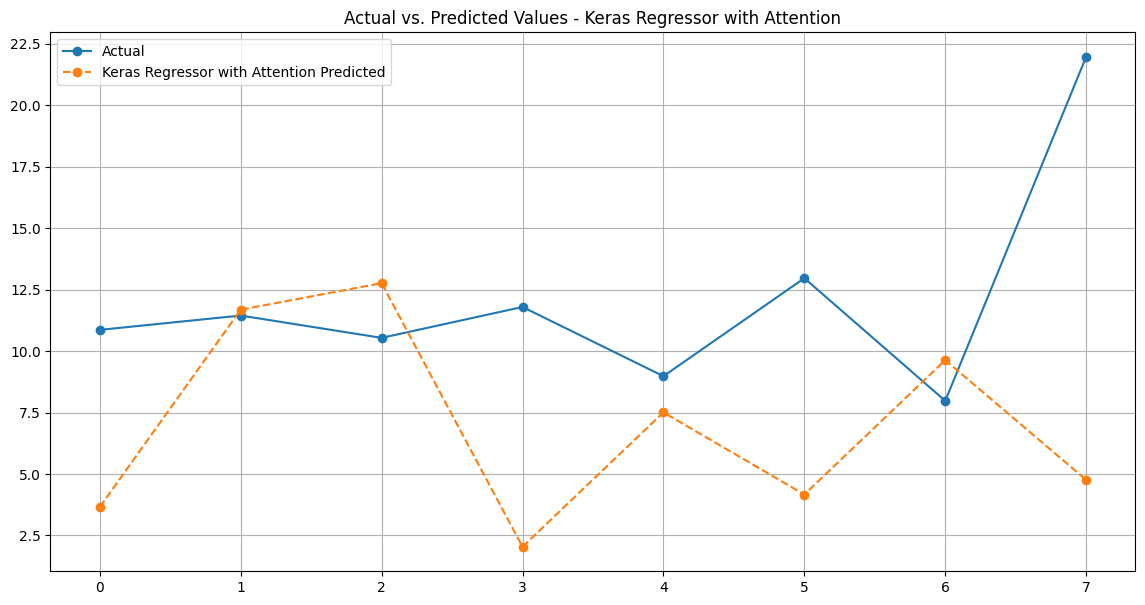


Results For Model: Keras Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'adam'}
Test RMSE: 8.4163
Test MSE: 70.8344
Test R2: -3.3760
Test MAE: 6.5174


,Actual,Predicted
0,10.86300,4.103266
1,11.44631,14.198700
2,10.53788,12.688385
3,11.79534,1.943350
4,8.97919,8.965331
5,12.96675,3.688061
6,7.97513,11.637777
7,21.97463,4.305172


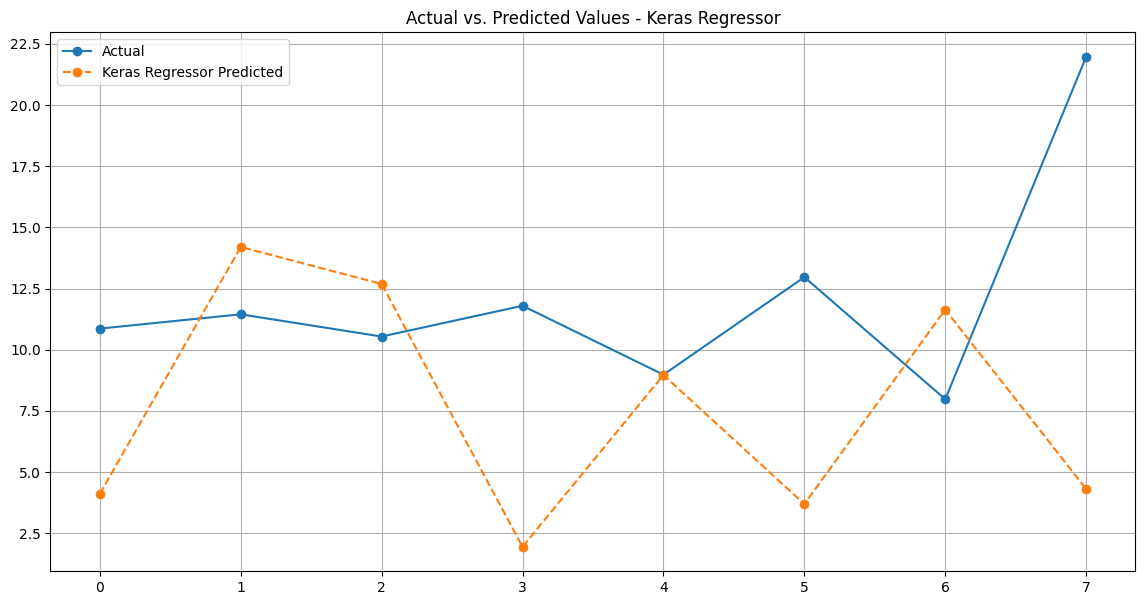


Results For Model: MLP Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'adam'}
Test RMSE: 8.6590
Test MSE: 74.9780
Test R2: -3.6320
Test MAE: 6.4041


,Actual,Predicted
0,10.86300,4.034453
1,11.44631,13.918899
2,10.53788,10.431512
3,11.79534,1.966564
4,8.97919,8.793996
5,12.96675,3.023558
6,7.97513,11.411053
7,21.97463,3.542107


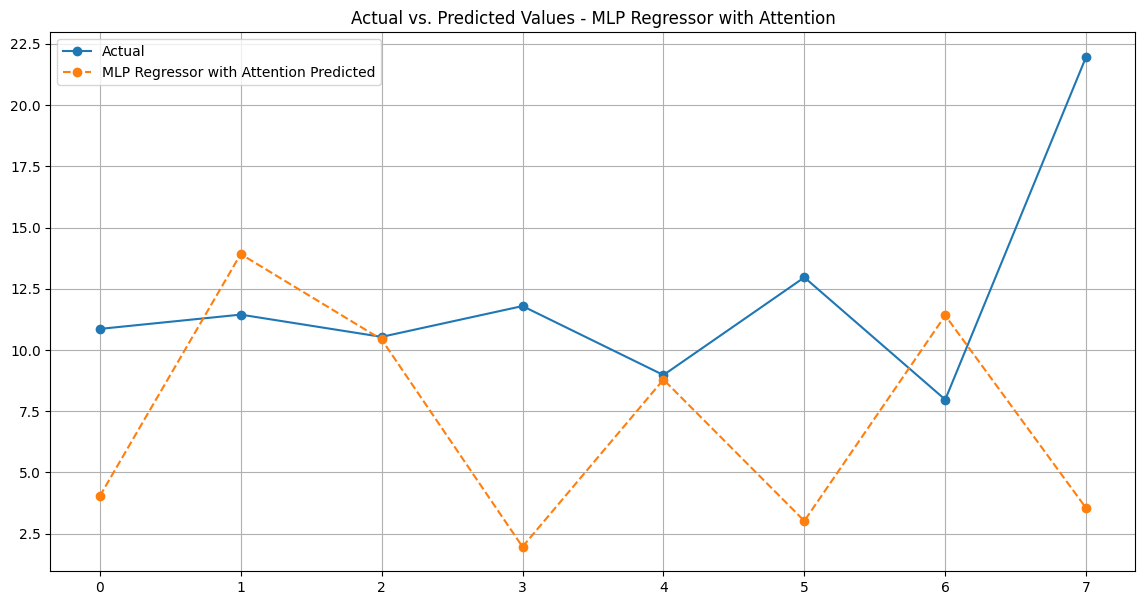

In [19]:
for result in results:
    model_name = result['name']
    print(f"Results For Model: {model_name}")
    print(f"Best Hyperparameters: {result['params']}")
    print(f"Test RMSE: {result['rmse']:.4f}")
    print(f"Test MSE: {result['mse']:.4f}")
    print(f"Test R2: {result['r2']:.4f}")
    print(f"Test MAE: {result['mae']:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [20]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,RNN Regressor,3.950357,15.605318,0.035932,2.686433
1,RNN Regressor with Attention,3.954048,15.634496,0.034129,2.874079
2,GRU Regressor,4.061205,16.493384,-0.018931,2.971784
3,GRU Regressor with Attention,4.122978,16.998946,-0.050164,3.050123
4,LSTM Regressor,4.246714,18.034580,-0.114144,3.152086
5,LSTM Regressor with Attention,4.503153,20.278384,-0.252762,2.988856
6,MLP Regressor,4.818568,23.218602,-0.434403,3.401777
7,Keras Regressor with Attention,8.146437,66.364434,-3.099875,6.071844
8,Keras Regressor,8.416316,70.834376,-3.376020,6.517409
9,MLP Regressor with Attention,8.658982,74.977967,-3.632003,6.404139
